In [1]:
import os
import json
from datasets import load_dataset
from PIL import Image
import numpy as np
from pathlib import Path

# Output directory structure
OUTPUT_DIR = "../datasets/signature-detection.v1.yolov9"
os.makedirs(f"{OUTPUT_DIR}/train/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/train/labels", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/valid/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/valid/labels", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/test/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/test/labels", exist_ok=True)

print("✓ Directory structure created")

c:\Users\user\Desktop\My_Projects\innovatex2025_armeta_solution\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Directory structure created


## Load Dataset from HuggingFace

In [2]:
print("Loading dataset from HuggingFace...")
dataset = load_dataset("tech4humans/signature-detection")

print(f"✓ Dataset loaded")
print(f"  - Train: {len(dataset['train'])} samples")
if 'validation' in dataset:
    print(f"  - Validation: {len(dataset['validation'])} samples")
if 'test' in dataset:
    print(f"  - Test: {len(dataset['test'])} samples")

# Show sample
print("\nSample data structure:")
sample = dataset['train'][0]
print(f"Keys: {sample.keys()}")
if 'objects' in sample:
    print(f"Objects keys: {sample['objects'].keys()}")

Loading dataset from HuggingFace...
✓ Dataset loaded
  - Train: 1980 samples
  - Validation: 420 samples
  - Test: 419 samples

Sample data structure:
Keys: dict_keys(['image_id', 'image', 'width', 'height', 'objects'])
Objects keys: dict_keys(['id', 'area', 'bbox', 'category'])


## Convert to YOLOv9 Format

YOLOv9 format: `<class_id> <x_center> <y_center> <width> <height>` (all normalized 0-1)

The dataset has bboxes in `[x, y, width, height]` format (absolute pixels), which we'll convert to YOLO format.

In [3]:
def convert_bbox_to_yolo(bbox, img_width, img_height):
    """
    Convert bbox from [x, y, width, height] to YOLO format
    [x_center_norm, y_center_norm, width_norm, height_norm]
    """
    x, y, w, h = bbox
    
    # Calculate center point
    x_center = x + w / 2
    y_center = y + h / 2
    
    # Normalize by image dimensions
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    
    return x_center_norm, y_center_norm, w_norm, h_norm


def process_split(dataset_split, split_name, output_dir):
    """
    Process a dataset split and save in YOLOv9 format
    """
    print(f"\nProcessing {split_name} split...")
    
    images_dir = Path(output_dir) / split_name / "images"
    labels_dir = Path(output_dir) / split_name / "labels"
    
    for idx, sample in enumerate(dataset_split):
        # Get image
        img = sample['image']
        
        # Handle different image types
        if isinstance(img, Image.Image):
            pil_img = img
        elif isinstance(img, np.ndarray):
            pil_img = Image.fromarray(img)
        else:
            print(f"Skipping {idx}: Unknown image type {type(img)}")
            continue
        
        # Convert to RGB if needed
        if pil_img.mode != 'RGB':
            pil_img = pil_img.convert('RGB')
        
        img_width, img_height = pil_img.size
        
        # Generate filename
        image_id = sample.get('image_id', idx)
        img_filename = f"img_{image_id:06d}.jpg"
        label_filename = f"img_{image_id:06d}.txt"
        
        # Save image
        img_path = images_dir / img_filename
        pil_img.save(img_path, 'JPEG')
        
        # Process annotations
        objects = sample.get('objects', {})
        bboxes = objects.get('bbox', [])
        categories = objects.get('category', [])
        
        # Write label file
        label_path = labels_dir / label_filename
        with open(label_path, 'w') as f:
            for bbox, category in zip(bboxes, categories):
                # Convert bbox to YOLO format
                x_center, y_center, w, h = convert_bbox_to_yolo(bbox, img_width, img_height)
                
                # Ensure values are in valid range [0, 1]
                x_center = max(0.0, min(1.0, x_center))
                y_center = max(0.0, min(1.0, y_center))
                w = max(0.0, min(1.0, w))
                h = max(0.0, min(1.0, h))
                
                # Write in YOLO format: class_id x_center y_center width height
                f.write(f"{category} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
        
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1} images...")
    
    print(f"✓ {split_name} split complete: {len(dataset_split)} images processed")

## Process All Splits

In [4]:
# Process train split
process_split(dataset['train'], 'train', OUTPUT_DIR)

# Process validation split (if exists)
if 'validation' in dataset:
    process_split(dataset['validation'], 'valid', OUTPUT_DIR)
else:
    # If no validation split, create one from train (10% split)
    print("\nNo validation split found, creating from train split (10%)...")
    train_split = dataset['train'].train_test_split(test_size=0.1, seed=42)
    process_split(train_split['train'], 'train', OUTPUT_DIR)
    process_split(train_split['test'], 'valid', OUTPUT_DIR)

# Process test split (if exists)
if 'test' in dataset:
    process_split(dataset['test'], 'test', OUTPUT_DIR)

print("\n" + "="*50)
print("✓ Dataset conversion complete!")


Processing train split...
  Processed 100 images...
  Processed 200 images...
  Processed 300 images...
  Processed 400 images...
  Processed 500 images...
  Processed 600 images...
  Processed 700 images...
  Processed 800 images...
  Processed 900 images...
  Processed 1000 images...
  Processed 1100 images...
  Processed 1200 images...
  Processed 1300 images...
  Processed 1400 images...
  Processed 1500 images...
  Processed 1600 images...
  Processed 1700 images...
  Processed 1800 images...
  Processed 1900 images...
✓ train split complete: 1980 images processed

Processing valid split...
  Processed 100 images...
  Processed 200 images...
  Processed 300 images...
  Processed 400 images...
✓ valid split complete: 420 images processed

Processing test split...
  Processed 100 images...
  Processed 200 images...
  Processed 300 images...
  Processed 400 images...
✓ test split complete: 419 images processed

✓ Dataset conversion complete!


## Create data.yaml Configuration File

In [5]:
# Create data.yaml file
yaml_content = """train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['signature', 'stamp', 'qr']

roboflow:
  workspace: tech4humans
  project: signature-detection
  version: 1
  license: Unknown
  url: https://huggingface.co/datasets/tech4humans/signature-detection
"""

yaml_path = Path(OUTPUT_DIR) / "data.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print("✓ data.yaml created")
print(f"\nDataset ready at: {OUTPUT_DIR}")
print("\nYou can now use this dataset with YOLOv9!")

✓ data.yaml created

Dataset ready at: ../datasets/signature-detection.v1.yolov9

You can now use this dataset with YOLOv9!


## Verify Conversion (Optional)

Check a few samples to ensure the conversion is correct.

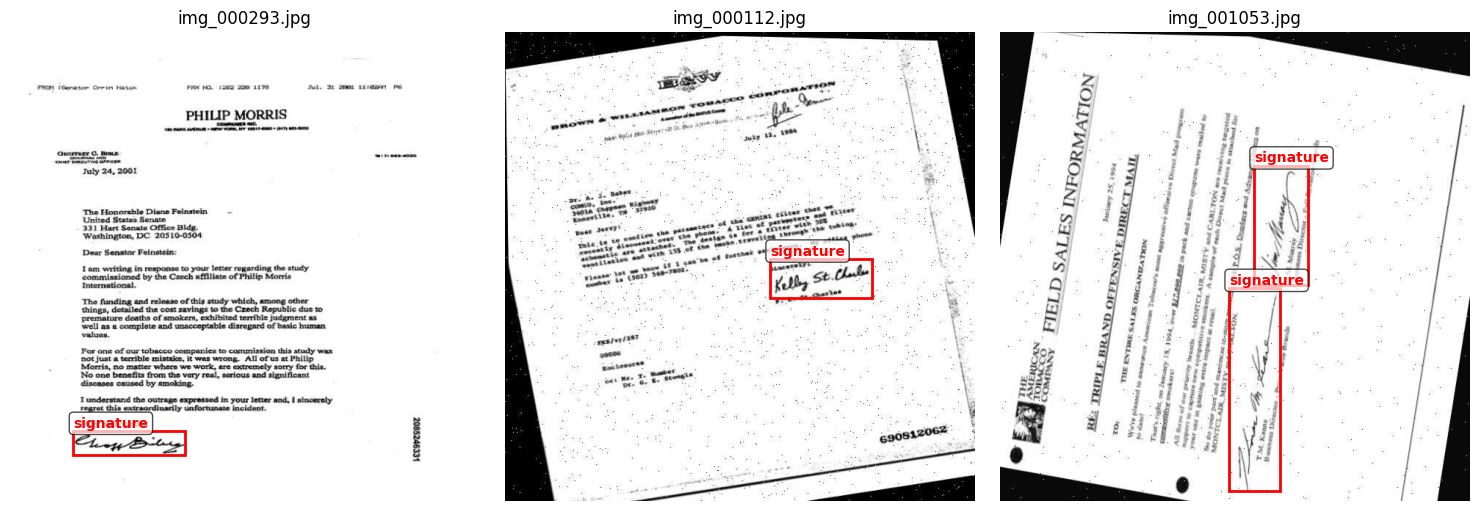

In [6]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(split='train', num_samples=2):
    """
    Visualize random samples with bounding boxes
    """
    images_dir = Path(OUTPUT_DIR) / split / "images"
    labels_dir = Path(OUTPUT_DIR) / split / "labels"
    
    image_files = list(images_dir.glob("*.jpg"))
    
    if not image_files:
        print(f"No images found in {split} split")
        return
    
    samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    if len(samples) == 1:
        axes = [axes]
    
    class_names = ['signature', 'stamp', 'qr']
    colors = ['red', 'blue', 'green']
    
    for ax, img_path in zip(axes, samples):
        # Load image
        img = Image.open(img_path)
        ax.imshow(img)
        
        img_width, img_height = img.size
        
        # Load corresponding label
        label_path = labels_dir / (img_path.stem + ".txt")
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center, y_center, w, h = map(float, parts[1:])
                        
                        # Convert back to pixel coordinates for visualization
                        x = (x_center - w/2) * img_width
                        y = (y_center - h/2) * img_height
                        w_px = w * img_width
                        h_px = h * img_height
                        
                        # Draw rectangle
                        rect = patches.Rectangle(
                            (x, y), w_px, h_px,
                            linewidth=2,
                            edgecolor=colors[class_id],
                            facecolor='none'
                        )
                        ax.add_patch(rect)
                        
                        # Add label
                        ax.text(
                            x, y - 5,
                            class_names[class_id],
                            color=colors[class_id],
                            fontsize=10,
                            weight='bold',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
                        )
        
        ax.set_title(img_path.name)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some samples
visualize_sample('train', num_samples=3)